#Puxar dados sidra

In [1]:
import os
import requests
import pandas as pd

# URL da API SIDRA para a Tabela 1757
url = "https://apisidra.ibge.gov.br/values/t/1757/p/2007-2022/n1/1/n3/all/v/allxp"

# Função para verificar e criar o diretório de destino
def verificar_criar_diretorio(diretorio):
    if not os.path.exists(diretorio):
        os.makedirs(diretorio)

# Função para fazer a requisição à API SIDRA
def obter_dados_sidra(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Erro na requisição: {response.status_code}")
        return None

# Função para ajustar o DataFrame, com cabeçalho e conversão de colunas
def ajustar_dataframe(data):
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]  # Definir a primeira linha como cabeçalho
    df = df.drop(0)  # Remover a linha que foi usada como cabeçalho
    df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce')  # Garantir que a coluna 'Ano' seja do tipo inteiro
    return df

# Função para filtrar os dados entre os anos especificados
def filtrar_dados_por_ano(df, inicio, fim):
    return df[df['Ano'].between(inicio, fim)]

# Função para salvar o DataFrame em um arquivo CSV
def salvar_csv(df, caminho):
    df.to_csv(caminho, index=False)
    print(f"Arquivo salvo em: {caminho}")

# Função principal para executar todas as etapas
def processar_dados_sidra(url, output_dir):
    verificar_criar_diretorio(output_dir)

    # Obter dados da API SIDRA
    dados = obter_dados_sidra(url)

    if dados:
        # Ajustar o DataFrame
        df = ajustar_dataframe(dados)

        # Verificar se a coluna 'Ano' está presente
        if 'Ano' in df.columns:
            # Filtrar os dados de 2007 a 2020 e de 2021 a 2022
            df_2007_2020 = filtrar_dados_por_ano(df, 2007, 2020)
            df_2021_2022 = filtrar_dados_por_ano(df, 2021, 2022)

            # Salvar os arquivos CSV
            salvar_csv(df_2007_2020, f'{output_dir}/dados_2007_2020.csv')
            salvar_csv(df_2021_2022, f'{output_dir}/dados_2021_2022.csv')
        else:
            print("A coluna 'Ano' não foi encontrada após o ajuste do cabeçalho.")
    else:
        print("Dados vazios ou inválidos retornados pela API.")

# Definir o diretório de destino
output_dir = 'data'

# Chamar a função principal
processar_dados_sidra(url, output_dir)


Arquivo salvo em: data/dados_2007_2020.csv
Arquivo salvo em: data/dados_2021_2022.csv


#Puxar dados da projeção populacional

In [2]:
import requests
import os
import pandas as pd
import numpy as np

# URL do arquivo de projeção de população no IBGE
ibge_url = "https://ftp.ibge.gov.br/Projecao_da_Populacao/Projecao_da_Populacao_2024/projecoes_2024_tab1_idade_simples.xlsx"
excel_file_path = "data/projecoes_2024_tab1_idade_simples.xlsx"
csv_input_path = "data/populacao.csv"
csv_output_path = "data/populacao_filtrada.csv"

# Função para baixar o arquivo do IBGE
def baixar_arquivo_ibge(url, output_path):
    print("Baixando arquivo do IBGE...")
    response = requests.get(url)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Criar diretório, se não existir
    with open(output_path, 'wb') as file:
        file.write(response.content)
    print(f"Arquivo baixado e salvo em: {output_path}")

# Função para salvar os dados do Excel em CSV (removendo as 5 primeiras linhas)
def salvar_csv(excel_path, csv_output_path):
    # Ler o arquivo Excel, ignorando as 5 primeiras linhas
    print("Lendo o arquivo Excel...")
    df_pop = pd.read_excel(excel_path, header=5)  # Pular as 5 primeiras linhas

    # Exibir as primeiras linhas para verificar a estrutura
    print("Estrutura do arquivo:")
    print(df_pop.head(15))

    # Exibir os nomes das colunas para verificar como são
    print("Colunas do arquivo:")
    print(df_pop.columns)

    # Salvar o arquivo em CSV sem filtrar nenhuma coluna
    print(f"Salvando os dados no CSV: {csv_output_path}")
    df_pop.to_csv(csv_output_path, index=False)
    return df_pop

# Função para filtrar a população na faixa etária de 38 a 58 anos e para os anos de 2007 a 2022
def filtrar_csv(csv_input_path, csv_output_path, faixa_etaria=(38, 58), anos=(2007, 2022)):
    # Ler o arquivo CSV
    print("Lendo o arquivo CSV...")
    df_pop = pd.read_csv(csv_input_path)

    # Exibir as primeiras linhas para verificar a estrutura
    print("Estrutura do arquivo:")
    print(df_pop.head(10))

    # Exibir os nomes das colunas para verificar como são
    print("Colunas do arquivo:")
    print(df_pop.columns)

    # Filtrar os dados de acordo com a faixa etária de 38 a 58 anos
    print("Filtrando a população na faixa etária de 38 a 58 anos...")
    df_pop = df_pop[(df_pop['IDADE'] >= faixa_etaria[0]) & (df_pop['IDADE'] <= faixa_etaria[1])]

    # Filtrar os dados para os anos entre 2007 e 2022
    anos_colunas = [str(ano) for ano in range(anos[0], anos[1] + 1)]
    df_pop = df_pop[['IDADE', 'SEXO', 'CÓD.', 'SIGLA', 'LOCAL'] + anos_colunas]

    # Interpolação para estimar os anos de 2021 e 2022 com base nos anos de 2007 a 2020
    print("Interpolando os dados para os anos de 2021 e 2022...")
    df_pop[anos_colunas] = df_pop[anos_colunas].apply(pd.to_numeric, errors='coerce')
    df_pop[anos_colunas] = df_pop[anos_colunas].interpolate(method='linear', axis=1)

    # Exibir as primeiras linhas para verificar a interpolação
    print("Estrutura do arquivo após interpolação:")
    print(df_pop.head(10))

    # Salvar os dados filtrados e interpolados em um novo arquivo CSV
    print(f"Salvando os dados filtrados em: {csv_output_path}")
    df_pop.to_csv(csv_output_path, index=False)
    return df_pop

# Baixar o arquivo do IBGE
baixar_arquivo_ibge(ibge_url, excel_file_path)

# Executar as funções
salvar_csv(excel_file_path, csv_input_path)
filtrar_csv(csv_input_path, csv_output_path)


Baixando arquivo do IBGE...
Arquivo baixado e salvo em: data/projecoes_2024_tab1_idade_simples.xlsx
Lendo o arquivo Excel...
Estrutura do arquivo:
    IDADE   SEXO  CÓD. SIGLA   LOCAL     2000     2001     2002     2003  \
0       0  Ambos     0    BR  Brasil  3423475  3347313  3274356  3212295   
1       1  Ambos     0    BR  Brasil  3450022  3406966  3332612  3261091   
2       2  Ambos     0    BR  Brasil  3461038  3444450  3401900  3327924   
3       3  Ambos     0    BR  Brasil  3469109  3458052  3441638  3399284   
4       4  Ambos     0    BR  Brasil  3477903  3466901  3455987  3439662   
5       5  Ambos     0    BR  Brasil  3482383  3476170  3465223  3454378   
6       6  Ambos     0    BR  Brasil  3483305  3480986  3474808  3463880   
7       7  Ambos     0    BR  Brasil  3481824  3481990  3479710  3473563   
8       8  Ambos     0    BR  Brasil  3471642  3480576  3480773  3478521   
9       9  Ambos     0    BR  Brasil  3459836  3470450  3479410  3479633   
10     10  Ambos 

,IDADE,SEXO,CÓD.,SIGLA,LOCAL,2007,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
38,38,Ambos,0,BR,Brasil,2660682,2685781,2718620,2756712,2790157,...,2884134,2965169,3061009,3161322,3250020,3316626,3354158,3368103,3374694,3379190
39,39,Ambos,0,BR,Brasil,2633141,2653360,2678496,2709537,2746037,...,2818784,2875716,2956445,3051848,3151742,3240079,3307993,3346256,3358329,3364339
40,40,Ambos,0,BR,Brasil,2609006,2625429,2645681,2669275,2698981,...,2772061,2810347,2867050,2947426,3042467,3142040,3231495,3299884,3336095,3347657
41,41,Ambos,0,BR,Brasil,2582419,2600871,2617325,2636259,2658736,...,2727836,2763552,2801675,2858089,2938162,3032917,3133441,3223135,3289283,3325060
42,42,Ambos,0,BR,Brasil,2546372,2573856,2592335,2607662,2625661,...,2680523,2719167,2754774,2792669,2848840,2928679,3024254,3124798,3212087,3277858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8972,54,Mulheres,53,DF,Distrito Federal,10826,11266,11684,12085,12508,...,13583,14236,14898,15527,16078,16708,17252,17686,18030,18348
8973,55,Mulheres,53,DF,Distrito Federal,10250,10732,11168,11580,11976,...,12889,13464,14112,14770,15396,15942,16566,17103,17519,17869
8974,56,Mulheres,53,DF,Distrito Federal,9653,10155,10632,11065,11472,...,12286,12772,13344,13988,14646,15268,15809,16424,16942,17365
8975,57,Mulheres,53,DF,Distrito Federal,9064,9558,10058,10533,10963,...,11760,12176,12659,13230,13874,14530,15148,15678,16272,16800


##Filtrar dados

###Sidra


In [6]:
import pandas as pd

# Definição dos caminhos dos arquivos CSV
file_paths = ["data/dados_2007_2020.csv", "data/dados_2021_2022.csv"]

# Importação dos arquivos CSV
dfs = [pd.read_csv(file) for file in file_paths]

# Concatenação dos DataFrames
df_combined = pd.concat(dfs, ignore_index=True)

# Obtendo os valores únicos de cada coluna
unique_values_per_column = {col: df_combined[col].unique() for col in df_combined.columns}

# Exibindo os valores únicos por coluna
for col, values in unique_values_per_column.items():
    print(f"Coluna: {col}")
    print(values)
    print("-" * 50)


Coluna: Nível Territorial (Código)
[1 3]
--------------------------------------------------
Coluna: Nível Territorial
['Brasil' 'Unidade da Federação']
--------------------------------------------------
Coluna: Unidade de Medida (Código)
[1020.   45.   40.   nan]
--------------------------------------------------
Coluna: Unidade de Medida
['Unidades' 'Pessoas' 'Mil Reais' nan]
--------------------------------------------------
Coluna: Valor
['96862' '51591' '1604331' '99846639' '29096468' '19436202' '43948062'
 '25975086' '2201778' '1249494' '24600330' '132622506' '123512827'
 '129192757' '61075996' '124291908' '63215915' '-' '106733' '56878'
 '1799556' '131703584' '38438714' '25574626' '58540902' '35029198'
 '2026667' '1036259' '32697297' '165592973' '153485444' '161859729'
 '79416611' '153841560' '74424948' '...' '63624' '2069815' '157145343'
 '48459062' '31974698' '67681909' '39792256' '2406760' '1032049'
 '38597614' '202173646' '187402817' '197930127' '93397908' '188525025'
 '95127

In [9]:
import pandas as pd

# Definição dos caminhos dos arquivos CSV
file_paths = ["data/dados_2007_2020.csv", "data/dados_2021_2022.csv"]

# Importação dos arquivos CSV
dfs = [pd.read_csv(file) for file in file_paths]

# Concatenação dos DataFrames
df_combined = pd.concat(dfs, ignore_index=True)

# Filtrando os dados para manter apenas as linhas onde "Variável" é "Número de empresas ativas"
df_filtered = df_combined[df_combined["Variável"] == "Número de empresas ativas"]

# Salvando o DataFrame filtrado em um novo arquivo CSV
df_filtered.to_csv("data/dados_filtrados_numero_empresas_ativas.csv", index=False)

# Exibindo as primeiras linhas do DataFrame filtrado
print(df_filtered.head())


    Nível Territorial (Código)     Nível Territorial  \
1                            1                Brasil   
18                           3  Unidade da Federação   
35                           3  Unidade da Federação   
52                           3  Unidade da Federação   
69                           3  Unidade da Federação   

    Unidade de Medida (Código) Unidade de Medida  Valor  Ano (Código)   Ano  \
1                       1020.0          Unidades  51591          2007  2007   
18                      1020.0          Unidades      -          2007  2007   
35                      1020.0          Unidades      -          2007  2007   
52                      1020.0          Unidades      -          2007  2007   
69                      1020.0          Unidades      -          2007  2007   

    Brasil e Unidade da Federação (Código) Brasil e Unidade da Federação  \
1                                        1                        Brasil   
18                                  

In [10]:
import pandas as pd

# Caminho do arquivo filtrado
file_path = "data/dados_filtrados_numero_empresas_ativas.csv"

# Carregando o DataFrame filtrado
df_filtered = pd.read_csv(file_path)

# Renomeando a coluna "Variável (Código)" para "Número de empresas ativas"
df_filtered.rename(columns={"Variável (Código)": "Número de empresas ativas"}, inplace=True)

# Removendo a coluna "Variável"
df_filtered.drop(columns=["Variável"], inplace=True)

# Salvando o DataFrame atualizado
df_filtered.to_csv(file_path, index=False)

# Exibindo as primeiras linhas do DataFrame atualizado
print(df_filtered.head())


   Nível Territorial (Código)     Nível Territorial  \
0                           1                Brasil   
1                           3  Unidade da Federação   
2                           3  Unidade da Federação   
3                           3  Unidade da Federação   
4                           3  Unidade da Federação   

   Unidade de Medida (Código) Unidade de Medida  Valor  Ano (Código)   Ano  \
0                      1020.0          Unidades  51591          2007  2007   
1                      1020.0          Unidades      -          2007  2007   
2                      1020.0          Unidades      -          2007  2007   
3                      1020.0          Unidades      -          2007  2007   
4                      1020.0          Unidades      -          2007  2007   

   Brasil e Unidade da Federação (Código) Brasil e Unidade da Federação  \
0                                       1                        Brasil   
1                                      11         

###Populacao

In [12]:
import pandas as pd

# Caminho do arquivo
file_path = "data/populacao_filtrada.csv"

# Carregando o DataFrame
df = pd.read_csv(file_path)

# Obtendo os valores únicos de cada coluna
unique_values_per_column = {col: df[col].unique() for col in df.columns}

# Exibindo os valores únicos por coluna
for col, values in unique_values_per_column.items():
    print(f"Coluna: {col}")
    print(values)
    print("-" * 50)


Coluna: IDADE
[38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58]
--------------------------------------------------
Coluna: SEXO
['Ambos' 'Homens' 'Mulheres']
--------------------------------------------------
Coluna: CÓD.
[ 0  1  2  3  4  5 11 12 13 14 15 16 17 21 22 23 24 25 26 27 28 29 31 32
 33 35 41 42 43 50 51 52 53]
--------------------------------------------------
Coluna: SIGLA
['BR' 'NO' 'ND' 'SD' 'SU' 'CO' 'RO' 'AC' 'AM' 'RR' 'PA' 'AP' 'TO' 'MA'
 'PI' 'CE' 'RN' 'PB' 'PE' 'AL' 'SE' 'BA' 'MG' 'ES' 'RJ' 'SP' 'PR' 'SC'
 'RS' 'MS' 'MT' 'GO' 'DF']
--------------------------------------------------
Coluna: LOCAL
['Brasil' 'Norte' 'Nordeste' 'Sudeste' 'Sul' 'Centro-Oeste' 'Rondônia'
 'Acre' 'Amazonas' 'Roraima' 'Pará' 'Amapá' 'Tocantins' 'Maranhão' 'Piauí'
 'Ceará' 'Rio Grande do Norte' 'Paraíba' 'Pernambuco' 'Alagoas' 'Sergipe'
 'Bahia' 'Minas Gerais' 'Espírito Santo' 'Rio de Janeiro' 'São Paulo'
 'Paraná' 'Santa Catarina' 'Rio Grande do Sul' 'Mato Grosso do Sul'
 'Ma

#Calcular a razão entre consumidores (38-58 anos) e empresas ativas por estado, interpolar/extrapolar 2021 e 2022, agrupar os estados por comportamento da série temporal e identificar estados saturados e com oportunidades futuras.

In [18]:
print("popullaação:\n", populacao_df.dtypes)
print("empresas ativas:\n", empresas_df.dtypes)

popullaação:
 SIGLA    object
LOCAL    object
2007      int64
2008      int64
2009      int64
2010      int64
2011      int64
2012      int64
2013      int64
2014      int64
2015      int64
2016      int64
2017      int64
2018      int64
2019      int64
2020      int64
2021      int64
2022      int64
dtype: object
empresas ativas:
 LOCAL                        object
Ano                           int64
Número de empresas ativas     int64
dtype: object


In [20]:
print(merged_df.duplicated(subset=["Ano", "LOCAL"], keep=False))
print(merged_df[merged_df.duplicated(subset=["Ano", "LOCAL"], keep=False)])


0        True
1        True
2        True
3        True
4        True
         ... 
28275    True
28276    True
28277    True
28278    True
28279    True
Length: 28280, dtype: bool
      SIGLA             LOCAL   Ano  População  Nível Territorial (Código)  \
0        BR            Brasil  2007  2660682.0                         1.0   
1        BR            Brasil  2007  2633141.0                         1.0   
2        BR            Brasil  2007  2609006.0                         1.0   
3        BR            Brasil  2007  2582419.0                         1.0   
4        BR            Brasil  2007  2546372.0                         1.0   
...     ...               ...   ...        ...                         ...   
28275   NaN       Mato Grosso  2022        NaN                         NaN   
28276   NaN             Goiás  2021        NaN                         NaN   
28277   NaN             Goiás  2022        NaN                         NaN   
28278   NaN  Distrito Federal  2021    

In [23]:
# Selecionar apenas colunas numéricas para agregação
colunas_numericas = ["Ano", "População", "Número de empresas ativas", "Razão População/Empresas"]

# Agrupar removendo duplicatas e mantendo apenas valores numéricos
merged_df = merged_df.groupby(["Ano", "LOCAL"], as_index=False)[colunas_numericas].mean()


In [25]:
print(merged_df.dtypes)


SIGLA                         object
LOCAL                         object
Ano                            int64
População                    float64
Número de empresas ativas    float64
Razão População/Empresas     float64
dtype: object


In [26]:
# Remover a coluna "SIGLA" antes de calcular a média, pois não pode ser agregada numericamente
merged_df = merged_df.drop(columns=["SIGLA"])

# Agrupar removendo duplicatas e mantendo apenas valores numéricos
merged_df = merged_df.groupby(["Ano", "LOCAL"], as_index=False).mean()


In [33]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

# Carregar os dados populacionais e de empresas ativas filtrados
populacao_df = pd.read_csv("data/populacao_filtrada.csv")
empresas_df = pd.read_csv("data/dados_filtrados_numero_empresas_ativas.csv")

# Selecionar apenas as colunas necessárias da população
anos = [str(ano) for ano in range(2007, 2023)]
populacao_df = populacao_df[["LOCAL"] + anos]

# Transformar anos de colunas para linhas
populacao_df = populacao_df.melt(id_vars=["LOCAL"], var_name="Ano", value_name="População")
populacao_df["Ano"] = populacao_df["Ano"].astype(int)

# Renomear colunas para padronização
empresas_df.rename(columns={"Brasil e Unidade da Federação": "LOCAL"}, inplace=True)

# Selecionar apenas colunas necessárias de empresas
empresas_df = empresas_df[["LOCAL", "Ano", "Número de empresas ativas"]]

# **Consolidar os dados antes do merge**
populacao_df = populacao_df.groupby(["Ano", "LOCAL"], as_index=False).sum()
empresas_df = empresas_df.groupby(["Ano", "LOCAL"], as_index=False).sum()

# **Fazer o merge dos dados**
merged_df = pd.merge(populacao_df, empresas_df, on=["LOCAL", "Ano"], how="inner")

# **Converter colunas numéricas**
merged_df["Número de empresas ativas"] = merged_df["Número de empresas ativas"].astype(float)
merged_df["População"] = merged_df["População"].astype(float)

# **Calcular a razão entre população e empresas ativas**
merged_df["Razão População/Empresas"] = merged_df["População"] / merged_df["Número de empresas ativas"]

# **Garantir que (Ano, LOCAL) seja único**
merged_df = merged_df.groupby(["Ano", "LOCAL"], as_index=False).agg({
    "População": "sum",
    "Número de empresas ativas": "sum",
    "Razão População/Empresas": "mean"
})

# **Remover linhas vazias**
merged_df.dropna(subset=["Razão População/Empresas"], inplace=True)

# **Interpolação para estimar 2021 e 2022**
estados = merged_df["LOCAL"].unique()
for estado in estados:
    estado_df = merged_df[merged_df["LOCAL"] == estado]

    if len(estado_df) < 2:
        continue

    anos_existentes = estado_df["Ano"].values
    razao_existente = estado_df["Razão População/Empresas"].values

    # Criar interpolador linear
    interpolador = interp1d(anos_existentes, razao_existente, kind='linear', fill_value="extrapolate")

    # Estimar valores para 2021 e 2022
    estimativas = interpolador([2021, 2022])

    # Adicionar ao DataFrame
    merged_df = pd.concat([
        merged_df,
        pd.DataFrame({"LOCAL": [estado, estado],
                      "Ano": [2021, 2022],
                      "Razão População/Empresas": estimativas})
    ], ignore_index=True)

# **Remover duplicatas antes da pivotagem**
merged_df = merged_df.drop_duplicates(subset=["Ano", "LOCAL"])

# **Criar matriz para clusterização**
X = merged_df.pivot(index="Ano", columns="LOCAL", values="Razão População/Empresas").fillna(method="ffill").T

# **Aplicar K-Means para identificar padrões de comportamento**
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Criar dicionário de mapeamento de cluster
cluster_map = {estado: cluster for estado, cluster in zip(X.index, clusters)}

# **Adicionar os clusters apenas para os estados presentes no agrupamento**
merged_df["Cluster"] = merged_df["LOCAL"].map(cluster_map)

# **Identificar estados saturados e com oportunidades**
media_razao_por_estado = merged_df[merged_df["Ano"].isin([2021, 2022])].groupby("LOCAL")["Razão População/Empresas"].mean()

# Determinar limiares de saturação e oportunidade com quartis
q75, q25 = np.percentile(media_razao_por_estado.dropna(), [75, 25])
saturados = media_razao_por_estado[media_razao_por_estado > q75].index.tolist()
oportunidades = media_razao_por_estado[media_razao_por_estado < q25].index.tolist()

# **Exibir os resultados**
print("\nEstados Saturados (Alta razão População/Empresas):")
print(saturados)

print("\nEstados com Oportunidades (Baixa razão População/Empresas):")
print(oportunidades)



# Criar diretório 'data' se não existir
os.makedirs("data", exist_ok=True)

# Caminho do arquivo para salvar os dados
merged_file_path = "data/merged_data.csv"

# Salvar o DataFrame
merged_df.to_csv(merged_file_path, index=False)

# Confirmar que o arquivo foi salvo
print(f"Arquivo salvo: {merged_file_path}")



Estados Saturados (Alta razão População/Empresas):
['Bahia', 'Brasil', 'Minas Gerais', 'Paraná', 'Rio Grande do Sul', 'Rio de Janeiro', 'São Paulo']

Estados com Oportunidades (Baixa razão População/Empresas):
['Acre', 'Amapá', 'Mato Grosso do Sul', 'Rondônia', 'Roraima', 'Sergipe', 'Tocantins']
Arquivo salvo: data/merged_data.csv


<ipython-input-33-bf6e41ca9c92>:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = merged_df.pivot(index="Ano", columns="LOCAL", values="Razão População/Empresas").fillna(method="ffill").T


#Gráficos

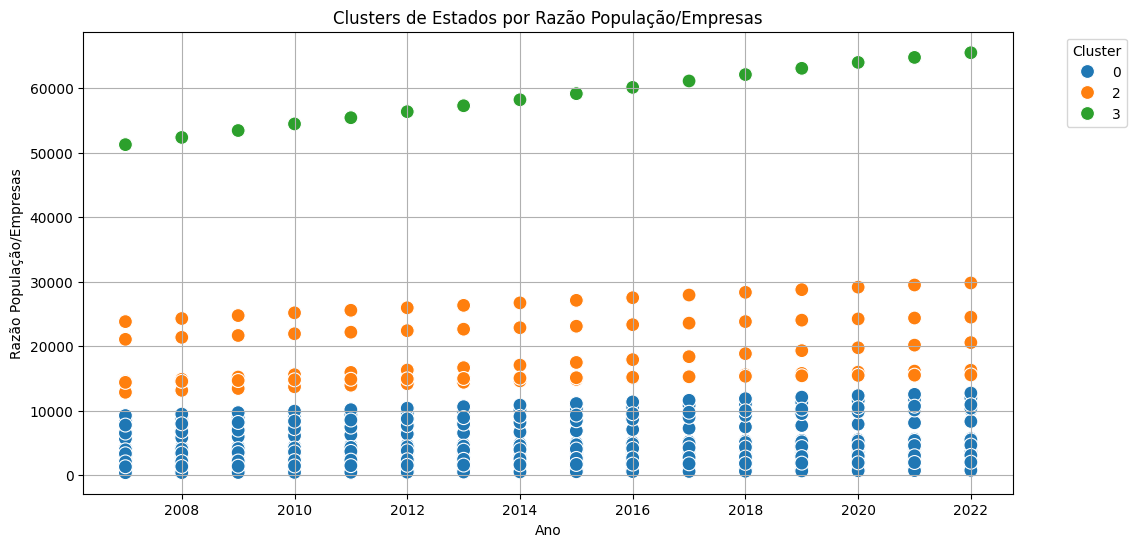

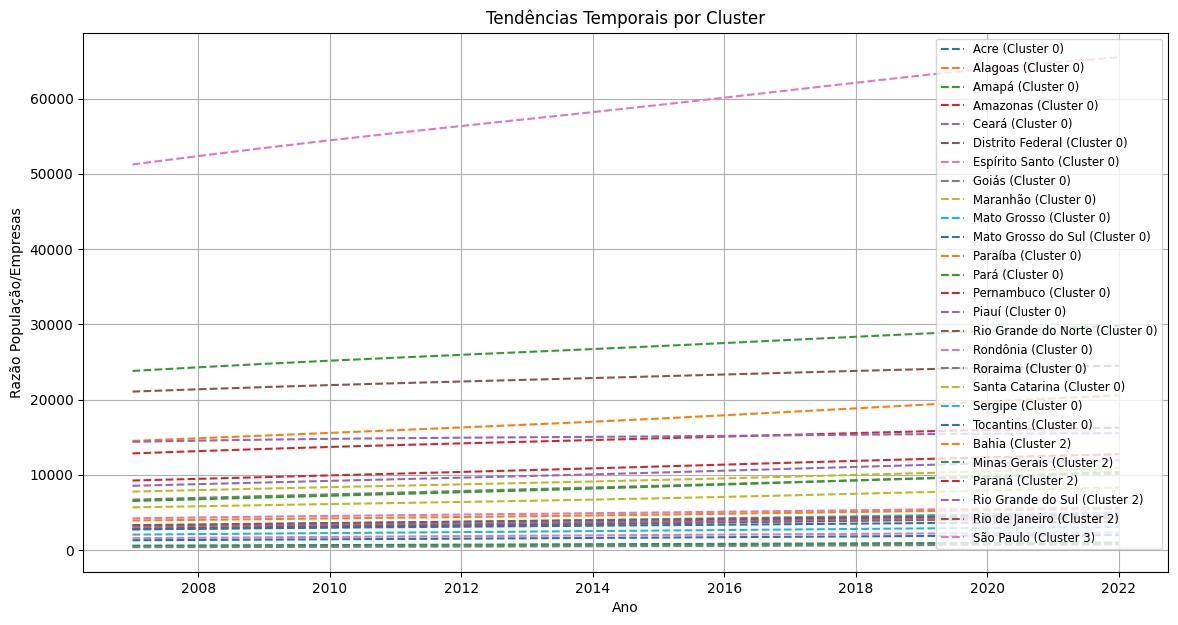

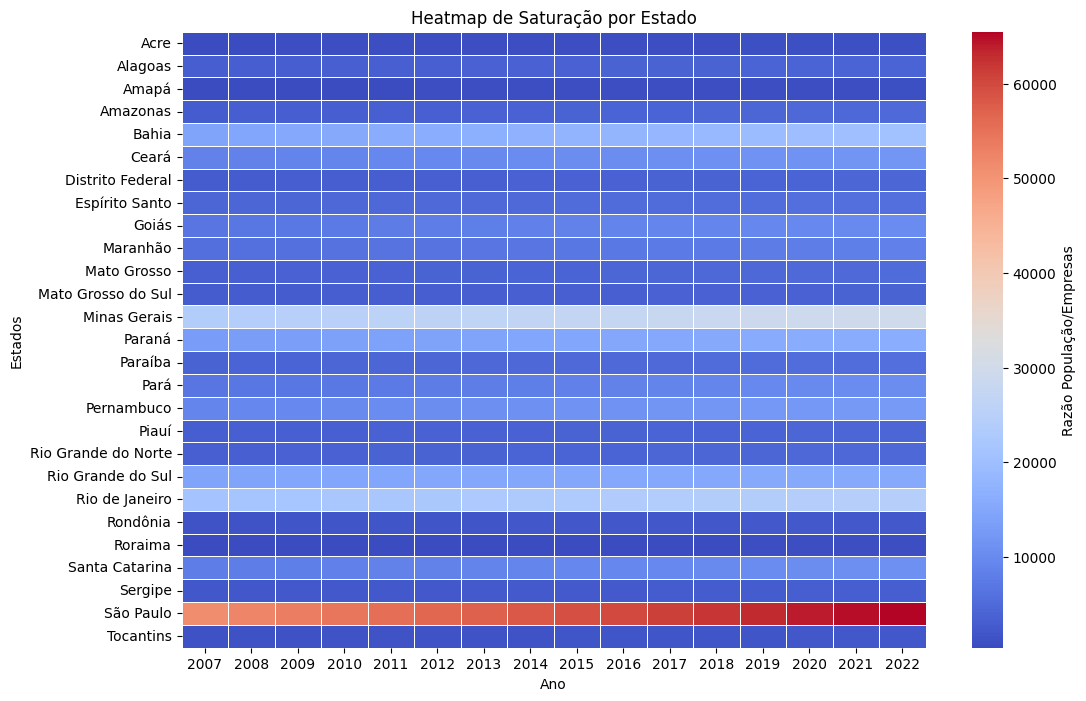


 Gráficos salvos em: resultados
- resultados/clusters_dispersao.png
- resultados/tendencias_temporais.png
- resultados/heatmap_saturacao.png

 Lista de estados por cluster salva em: resultados/clusters_estados.txt


In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Criar diretório para salvar os gráficos
output_dir = "resultados"
os.makedirs(output_dir, exist_ok=True)

# Verificar se o arquivo merged_data.csv existe
merged_file_path = "data/merged_data.csv"
if not os.path.exists(merged_file_path):
    print(f"Erro: O arquivo '{merged_file_path}' não foi encontrado. Execute o processamento dos dados primeiro.")
else:
    # Carregar os dados processados do arquivo CSV
    merged_df = pd.read_csv(merged_file_path)

    # Remover "Brasil" dos gráficos
    merged_df = merged_df[merged_df["LOCAL"] != "Brasil"]

    # Garantir que as colunas numéricas estão no formato correto
    merged_df["Ano"] = merged_df["Ano"].astype(int)
    merged_df["Razão População/Empresas"] = merged_df["Razão População/Empresas"].astype(float)
    merged_df["Cluster"] = merged_df["Cluster"].astype(int)

    # Criar um dicionário para armazenar os estados por cluster
    cluster_estados = {}
    for cluster in merged_df["Cluster"].unique():
        estados_cluster = merged_df[merged_df["Cluster"] == cluster]["LOCAL"].unique().tolist()
        cluster_estados[cluster] = estados_cluster

    # **1️ Gráfico de Dispersão dos Clusters**
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=merged_df["Ano"], y=merged_df["Razão População/Empresas"],
                    hue=merged_df["Cluster"], palette="tab10", s=100)

    plt.xlabel("Ano")
    plt.ylabel("Razão População/Empresas")
    plt.title("Clusters de Estados por Razão População/Empresas")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)

    # Salvar o gráfico
    scatterplot_path = os.path.join(output_dir, "clusters_dispersao.png")
    plt.savefig(scatterplot_path, bbox_inches="tight")
    plt.show()

    # **2️Gráfico de Linhas - Tendência Temporal de cada Cluster**
    plt.figure(figsize=(14, 7))
    for cluster, estados_cluster in cluster_estados.items():
        for estado in estados_cluster:
            subset = merged_df[merged_df["LOCAL"] == estado]
            plt.plot(subset["Ano"], subset["Razão População/Empresas"], label=f"{estado} (Cluster {cluster})", linestyle="--")

    plt.xlabel("Ano")
    plt.ylabel("Razão População/Empresas")
    plt.title("Tendências Temporais por Cluster")
    plt.legend(loc="upper right", fontsize="small")
    plt.grid(True)

    #  Salvar o gráfico
    lineplot_path = os.path.join(output_dir, "tendencias_temporais.png")
    plt.savefig(lineplot_path, bbox_inches="tight")
    plt.show()

    #  **3️ Heatmap de Saturação por Estado**
    pivot_data = merged_df.pivot(index="LOCAL", columns="Ano", values="Razão População/Empresas")

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, cmap="coolwarm", linewidths=0.5, annot=False, cbar_kws={'label': 'Razão População/Empresas'})

    plt.xlabel("Ano")
    plt.ylabel("Estados")
    plt.title("Heatmap de Saturação por Estado")

    #  Salvar o gráfico
    heatmap_path = os.path.join(output_dir, "heatmap_saturacao.png")
    plt.savefig(heatmap_path, bbox_inches="tight")
    plt.show()

    #  **Salvar a lista de estados por cluster em um arquivo de texto**
    cluster_info_path = os.path.join(output_dir, "clusters_estados.txt")
    with open(cluster_info_path, "w") as f:
        for cluster, estados in cluster_estados.items():
            f.write(f"Cluster {cluster}:\n")
            f.write(", ".join(estados) + "\n\n")

    # Confirmar os arquivos salvos
    print(f"\n Gráficos salvos em: {output_dir}")
    print(f"- {scatterplot_path}")
    print(f"- {lineplot_path}")
    print(f"- {heatmap_path}")
    print(f"\n Lista de estados por cluster salva em: {cluster_info_path}")
